In [1]:
import numpy as np
from scipy import linalg as lg
from imageio import imread
from matplotlib import pyplot as plt
import scipy.sparse as sparse
import scipy.sparse.linalg as lg2
import math

In [4]:
def get_neighbors(index, radius, height, width):
    """Calculate the flattened indices of the pixels that are within the given
    distance of a central pixel, and their distances from the central pixel.

    Parameters:
        index (int): The index of a central pixel in a flattened image array
            with original shape (radius, height).
        radius (float): Radius of the neighborhood around the central pixel.
        height (int): The height of the original image in pixels.
        width (int): The width of the original image in pixels.

    Returns:
        (1-D ndarray): the indices of the pixels that are within the specified
            radius of the central pixel, with respect to the flattened image.
        (1-D ndarray): the euclidean distances from the neighborhood pixels to
            the central pixel.
    """
    # Calculate the original 2-D coordinates of the central pixel.
    row, col = index // width, index % width

    # Get a grid of possible candidates that are close to the central pixel.
    r = int(radius)
    x = np.arange(max(col - r, 0), min(col + r + 1, width))
    y = np.arange(max(row - r, 0), min(row + r + 1, height))
    X, Y = np.meshgrid(x, y)

    # Determine which candidates are within the given radius of the pixel.
    R = np.sqrt(((X - col)**2 + (Y - row)**2))
    mask = R < radius
    return (X[mask] + Y[mask]*width).astype(np.int), R[mask]

In [5]:
class ImageSegmenter:
    """Class for storing and segmenting images."""
    def __init__(self, filename):
        """Read the image file. Store its brightness values as a flat array."""
        self.image = imread(filename)
        scaled = self.image / 255
        if len(self.image.shape) == 3:
            self.brightness = scaled.mean(axis = 2)
        else:
            self.brightness = scaled

    def show_original(self):
        """Display the original image."""
        if len(self.image.shape) == 3:
            plt.imshow(self.image)
            #plt.axis('off')
            plt.show()
        else:
            plt.imshow(self.brightness, cmap = "gray")
            #plt.axis('off')
            plt.show()

    def adjacency(self, r=5., sigma_B2=.02, sigma_X2=3.):
        """Compute the Adjacency and Degree matrices for the image graph."""
        Bright_ravel = np.ravel(self.brightness)
        def get_weights(i, neighbors, distances):
            """ Compute weights for each index """
            weights = []
            for j in range(len(neighbors)):
                B = abs(Bright_ravel[i] - Bright_ravel[neighbors[j]]) / sigma_B2
                X = distances[j] / sigma_X2
                weights.append(math.exp(-B - X))
            return weights

        #Set up Matricies
        m,n = self.image.shape[0:2]
        A = sparse.lil_matrix((m*n, m*n))
        D = np.empty((m*n))
        for i in range(m*n):
            #fill A, D with appropriate values
            neighbors, distances = get_neighbors(i, r, m, n)
            weights = get_weights(i, neighbors, distances)
            A[i, neighbors] = weights
            D[i] = sum(weights)
        A = sparse.csc_matrix(A)
        return A, D

    def cut(self, A, D):
        """Compute the boolean mask that segments the image."""
        L = sparse.csgraph.laplacian(A)

        # D needs to be 48x48 but it is 2304x1
        def d_half(num):
            return 1/math.sqrt(num)

        #Do crazy stuff to make it the right shape
        D_temp = np.vectorize(d_half)
        D[:] = D_temp(D[:])
        D = D.reshape((1,-1))
        D = D[0,:]
        D = sparse.diags(D)
        C = D @ L @ D
        eigs = lg2.eigsh(C, k = 2, which="SM")[1][:,1]

        #create 2-D mask
        m,n = self.image.shape[0:2]
        eigs = eigs.reshape((m,n))
        mask = eigs > 0
        return mask

    def segment(self, r=5., sigma_B=.02, sigma_X=3.):
        """Display the original image and its segments."""
        A, D = self.adjacency(r,sigma_B, sigma_X)
        mask = self.cut(A,D)

        #Plot grey image
        if len(self.image.shape) == 2:
            ax1 = plt.subplot(311)
            ax1.imshow(self.image,cmap = "gray")
            ax2 = plt.subplot(312)
            ax2.imshow(self.image * mask,cmap = "gray")
            ax3 = plt.subplot(313)
            ax3.imshow(self.image * ~mask,cmap = "gray")
        #Plot color image
        else:
            ax1 = plt.subplot(311)
            ax1.imshow(self.image)
            ax2 = plt.subplot(312)
            ax2.imshow(self.image * np.dstack((mask,mask,mask)))
            ax3 = plt.subplot(313)
            ax3.imshow(self.image * np.dstack((~mask,~mask,~mask)))
        plt.show()

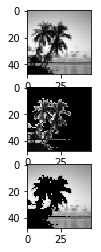

In [6]:
ImageSegmenter("dream_gray.png").segment()

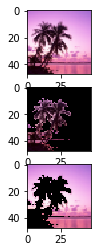

In [7]:
ImageSegmenter("dream.png").segment()